### Applying machine learning to guide ensemble curation

An ensemble of models can be though of as a set of feasible hypotheses about how a system behaves. From a machine learning perspective, these hypotheses can alternatively be viewed as samples (or observations), each of which has a distinct set of features (i.e. the model components that vary across an ensemble) and can further generate new features by performing simulations. An example of the analyses enabled by this view of ensembles can be found in [Medlock & Papin](https://doi.org/10.1101/460071), where ensemble structure and ensemble simulations are used to identify reactions that are high-priority targets for curation.

In this example, we demonstrate how ensembles of genome-scale metabolic models and machine learning can be combined to identify reactions that might strongly influence a single prediction (flux through biomass). We will use an ensemble for *Staphylococcus aureus* that contains 1000 members. The ensemble was generated through iterative gapfilling to enable growth on single C/N media conditions using a draft reconstruction from ModelSEED.

In [1]:
import medusa
from medusa.test import create_test_ensemble

ensemble = create_test_ensemble("Staphylococcus aureus")

Using the ensemble, we'll perform flux balance analysis and return flux through the biomass reaction (which has an ID of `"bio1"`). The ensemble already has the media conditions set as "complete", meaning the boundary reactions for all transportable metabolites are open (e.g. the lower bound of all exchange reactions is -1000).

In [2]:
from medusa.flux_analysis import flux_balance
biomass_fluxes = flux_balance.optimize_ensemble(ensemble,return_flux="bio1")

The `optimize_ensemble` function returns a pandas DataFrame, where each column is a reaction and each row is an ensemble member. For illustration, here are the values for the first 10 members of the ensemble:

In [3]:
biomass_fluxes.head(10)

,bio1
Staphylococcus aureus_gapfilled_811,108.211707
Staphylococcus aureus_gapfilled_745,110.002525
Staphylococcus aureus_gapfilled_594,110.490240
Staphylococcus aureus_gapfilled_645,121.841358
Staphylococcus aureus_gapfilled_84,116.367655
Staphylococcus aureus_gapfilled_670,128.721837
Staphylococcus aureus_gapfilled_370,109.964123
Staphylococcus aureus_gapfilled_778,114.100755
Staphylococcus aureus_gapfilled_59,124.279404
Staphylococcus aureus_gapfilled_975,100.490064


To get a sense for the distribution of biomass flux predictions, we can visualize them with matplotlib:

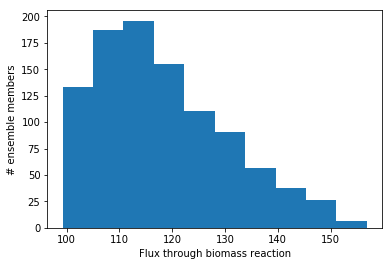

In [12]:
import matplotlib.pylab as plt
fig, ax = plt.subplots()
plt.hist(biomass_fluxes['bio1'])
ax.set_ylabel('# ensemble members')
ax.set_xlabel('Flux through biomass reaction')
plt.show()

As you can see, there is quite a bit of variation in the maximum flux through biomass! Keep in mind that this is an ensemble of gapfilled reconstructions with no manual curation, and that none of the uptake rates are reallistically constrained, so these predictions are unrealistically high (100 units of flux through biomass is a doubling time of 36 seconds, at least an order of magnitude faster than even the fittest *E. coli* grown *in vitro*).

Our goal now is to identify which features in the ensemble are predictive of flux through biomass. If we can identify these reactions, then turn to the literature or perform an experiment to figure out whether they are really catalyzed by the organism, we can greatly reduce the uncertainty in our predictions of biomass flux!

Given that we have a continous output, our problem can be addressed using regression. We will use the binary presence/absence of each reaction in each member of the ensemble as input to a random forest regressor, implemented in [scikit-learn](https://scikit-learn.org/stable/). Many supervised regression models will work for this analysis, but random forest is particularly easy to understand and interpret when the input is binary (i.e. reaction presence/absence).

In [5]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

We reformat the data here, getting the feature states for each ensemble member and converting them to `True`/`False`, then combine them into a single DataFrame with the biomass flux predictions for matched members.

In [6]:
# Grab the features and states for the ensemble and convert to a dataframe
import pandas as pd
feature_dict = {}
for feature in ensemble.features:
    feature_dict[feature.id] = feature.states
feature_frame = pd.DataFrame.from_dict(feature_dict)
# convert the presence and absence of features to a boolean value
feature_frame = feature_frame.astype(bool)
# extract biomass and add it to the dataframe, keeping track of the feature names
input_cols = feature_frame.columns
biomass_fluxes.index = [member.id for member in biomass_fluxes.index]
feature_frame['bio1'] = biomass_fluxes['bio1']

Now we actually construct and fit the random forest regressor, using 100 total trees in the forest. The `oob_score_` reported here is the coefficient of determination (R<sup>2</sup>) calculated using the out-of-bag samples for each tree. As a reminder, R<sup>2</sup> varies from 0 to 1.0, where 1.0 is a perfect fit.

In [7]:
# create a regressor to predict biomass flux from reaction presence/absence
regressor = RandomForestRegressor(n_estimators=100,oob_score=True)
fit_regressor = regressor.fit(X=feature_frame[input_cols],y=feature_frame['bio1'])
fit_regressor.oob_score_

0.8596844820387041

With a reasonably-performing regressor in hand, we can inspect the important features to identify reactions that contribute to uncertainty in biomass flux predictions.

In [8]:
imp_frame = pd.DataFrame(fit_regressor.feature_importances_,
                        index=feature_frame[input_cols].columns).sort_values(
                        by=0,ascending=False)
imp_frame.columns = ['importance']

In [9]:
imp_frame.head(10)

,importance
rxn01640_c_lower_bound,0.140617
rxn01640_c_upper_bound,0.116075
rxn00602_c_lower_bound,0.064369
rxn12585_c_upper_bound,0.042615
rxn00602_c_upper_bound,0.042277
rxn12585_c_lower_bound,0.037453
rxn15617_c_lower_bound,0.030866
rxn15617_c_upper_bound,0.029296
rxn23244_c_upper_bound,0.022884
rxn23244_c_lower_bound,0.021674


With the list of important features in hand, the first thing we should do is turn to the literature to see if someone else has already figured out whether these reactions are present or absent in *Staphylococcus aureus*. The top reaction, `rxn01640`, is N-Formimino-L-glutamate iminohydrolase, which is part of the histidine utilization pathway. A quick consultation with a [review on the regulation of histidine utilization in bacteria](https://mmbr.asm.org/content/76/3/565) suggests that the enzyme for this reaction, encoded by the *hutF* gene, is widespread and conserved amongst bacteria. However, the *hutF* gene is part of a second, less common pathway that branches off of the primary histidine utilization pathway. If we consult [PATRIC with a search for the *hutF* gene](https://www.patricbrc.org/view/FeatureList/?keyword(HutF)), we see that, although the gene is widespread, there is no predicted *hutF* gene in any sequenced *Staphylococcus aureus* genome. Although absence of evidence is not evidence of absence, we can be relatively confident that *hutF* is not encoded in the *Staphylococcus aureus* genome, given how well-studied this pathogen is.

What happens if we "correct" this issue in the ensemble? Let's inactivate the lower and upper bound for the reaction in all the members, then perform flux balance analysis again.

In [10]:
for member in ensemble.features.get_by_id('rxn01640_c_lower_bound').states:
    ensemble.features.get_by_id('rxn01640_c_lower_bound').states[member] = 0
    ensemble.features.get_by_id('rxn01640_c_upper_bound').states[member] = 0
    
biomass_fluxes_post_curation = flux_balance.optimize_ensemble(ensemble,return_flux="bio1")

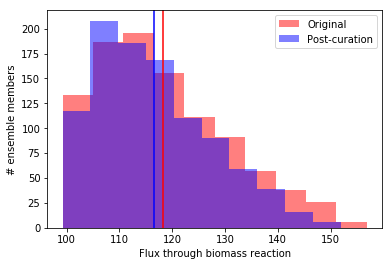

In [11]:
import matplotlib.pylab as plt
fig, ax = plt.subplots()
plt.hist(biomass_fluxes['bio1'], label = 'Original', alpha = 0.5, color='red')
plt.hist(biomass_fluxes_post_curation['bio1'], label = 'Post-curation', alpha = 0.5, color = 'blue')
plt.axvline(x=biomass_fluxes['bio1'].mean(), c = 'red')
plt.axvline(x=biomass_fluxes_post_curation['bio1'].mean(), c = 'blue')
ax.set_ylabel('# ensemble members')
ax.set_xlabel('Flux through biomass reaction')
plt.legend(loc='upper right')
plt.show()

Here, we show the old distribution in red and the new distribution in blue, with vertical lines at the mean in the same color. As you can see, by resolving the identity of the `hutF`-encoded enzyme, we've reduced the mean and range of predicted flux through biomass. The reduction here is modest, but the process can be repeated for the other important features we identified to continue to refine the distribution and improve the reconstruction in a rational way.